In [1]:
import networkx as nx
import random
import itertools

import torch
import torch_geometric as pyg
from torch_geometric.nn import GraphSAGE
from torch_geometric.utils import from_networkx, to_networkx
torch.manual_seed(0)
random.seed(0)

def create_dataset():
        g = nx.Graph()
        for i in range(2000):
            g.add_node(i)

        colors = [1] * 10 + [2] * 10 + [3] * 10 + [0] * 1970
        # blue =1
        # red =2
        blue_nodes = [i for i in g.nodes() if colors[i] == 1]
        red_nodes = [i for i in g.nodes() if colors[i] == 2]
        green_nodes = [i for i in g.nodes() if colors[i] == 3]
        white_nodes = [i for i in g.nodes() if colors[i] == 0]
        # labels 3: green
        # labels 2: red
        # labels 1: blue
        # labels 0: none
        labels = colors[:30] + [1] * 990 + [2] * 990
        P = 0.005  # probability of edge between two white nodes
        for u, v in itertools.combinations(white_nodes, 2):
            if random.random() < P:
                g.add_edge(u, v)

        blue_red_green_combs = list(itertools.permutations(list(range(1, 11)), 3))

        nodes_to_test = []
        for idx, node in enumerate(white_nodes):
            idx = idx % len(blue_red_green_combs)
            blue_count, red_count, green_count = blue_red_green_combs[idx]
            if (red_count > blue_count and red_count > green_count \
                or blue_count > red_count and blue_count > green_count \
                or green_count > red_count and green_count > blue_count) \
                    and min(red_count, blue_count, green_count) > 1:
                nodes_to_test.append(node)
            for u in random.sample(blue_nodes, blue_count):
                g.add_edge(node, u)
            for u in random.sample(red_nodes, red_count):
                g.add_edge(node, u)
            for u in random.sample(green_nodes, green_count):
                g.add_edge(node, u)
            if blue_count > red_count and blue_count > green_count:
                labels[node] = 1
            elif red_count > blue_count and red_count > green_count:
                labels[node] = 2
            else:
                labels[node] = 3
        labels = [x - 1 for x in labels]
        data = from_networkx(g)
        data.x = torch.nn.functional.one_hot(torch.tensor(colors)).float()
        data.y = torch.tensor(labels)
        data.num_classes = 3
        data.nodes_to_test = nodes_to_test
        return data

In [2]:
directory = 'more_multiclass_neg_evidence/'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:6')

In [3]:
train_data = [create_dataset().to(device) for i in range(4)]
test_data = create_dataset().to(device)

In [4]:
model = GraphSAGE(4, 3, 1, 3, **{'aggr' : 'sum', 'bias' : False, 'root_weight' : False}).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
from tqdm import tqdm
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.nodes_to_test], data.y[data.nodes_to_test])
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.01 * torch.norm(param, p = 1)
    reg_loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x, data.edge_index).argmax(1)
    test_correct = int((pred[data.nodes_to_test] == data.y[data.nodes_to_test]).sum())
    test_acc = test_correct / len(data.nodes_to_test)
    return test_acc

pbar = tqdm(range(1, 1001))
for epoch in pbar:
    loss = 0
    for data in train_data:
        loss += train(data)
    test_acc = test(test_data)
    pbar.set_description(f'Loss: {loss/4:.4f}, Test Acc: {test_acc:.4f}')
pbar.close()
model.eval()

Loss: 0.1033, Test Acc: 1.0000: 100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


GraphSAGE(4, 3, num_layers=1)

In [6]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 3.0977e-04,  2.3981e+00, -5.4696e-04, -3.4883e-04],
        [ 1.7874e-05,  2.8829e-04,  2.4045e+00, -3.7745e-04],
        [-2.5918e-04, -2.7572e-04, -6.7056e-04,  2.4051e+00]], device='cuda:6',
       requires_grad=True)


In [7]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, CaptumExplainer, ThresholdConfig

giexplainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('InputXGradient').to(device),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
)

In [8]:
gi_expls = []
for index in test_data.nodes_to_test:
    gi_expls.append(giexplainer(test_data.x, test_data.edge_index, index=index).cpu())

/home/jesse/miniconda3/envs/explainer_env/lib/python3.10/site-packages/captum/attr/_utils/gradient.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if input.grad is not None:
/home/jesse/miniconda3/envs/explainer_env/lib/python3.10/site-packages/captum/attr/_utils/gradient.py:65: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for

In [9]:
gnnexplainer_class = Explainer(
    model=model,
    algorithm=GNNExplainer(edge_ent = 0.0, edge_size = 0.001, lr = 0.5).to(device),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
)

In [10]:
gnn_class_expls = []
for index in test_data.nodes_to_test:
    gnn_class_expls.append(gnnexplainer_class(test_data.x, test_data.edge_index, index=index).cpu())

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
idx = 31
index = test_data.nodes_to_test[idx]
print(data.y[index])
hard_edge_mask = (test_data.edge_index[1] == index).cpu()
edge_index = test_data.edge_index[:, hard_edge_mask]
edge_list = []
G = nx.DiGraph()
for j in range(edge_index.shape[1]):
    G.add_edge(int(edge_index[0,j]), int(edge_index[1,j]))
    edge_list.append((int(edge_index[0,j]), int(edge_index[1,j])))

gi_mask_dict = {edge_list[j] : float(gi_expls[idx].edge_mask[hard_edge_mask][j])
                for j in range(G.number_of_edges())}

gnn_mask_dict = {edge_list[j] : float(gnn_class_expls[idx].edge_mask[hard_edge_mask][j])
                for j in range(G.number_of_edges())}

nx.set_edge_attributes(G, gi_mask_dict, 'GradientXInput')

nx.set_edge_attributes(G, gnn_mask_dict, 'GNNExplainer')

draw_graph = G.to_undirected()
for node in G:
    for ngbr in nx.neighbors(G, node):
        if node in nx.neighbors(G, ngbr):
            draw_graph.edges[node, ngbr]['GradientXInput'] = (
                G.edges[node, ngbr]['GradientXInput'] + G.edges[ngbr, node]['GradientXInput']
            )
            draw_graph.edges[node, ngbr]['GNNExplainer'] = (
                G.edges[node, ngbr]['GNNExplainer'] + G.edges[ngbr, node]['GNNExplainer']
            )
node_color = ["blue" if torch.all(test_data.x[u].cpu() == torch.tensor([0., 1., 0., 0.]))
              else 'red' if torch.all(test_data.x[u].cpu() == torch.tensor([0., 0., 1., 0.]))
              else 'green' if torch.all(test_data.x[u].cpu() == torch.tensor([0., 0., 0., 1.]))
              else 'gray' for u in draw_graph.nodes()]
node_shape = ['s' if torch.all(test_data.x[u].cpu() == torch.tensor([0., 1., 0., 0.]))
              else '^' if torch.all(test_data.x[u].cpu() == torch.tensor([0., 0., 1., 0.]))
              else 'p' if torch.all(test_data.x[u].cpu() == torch.tensor([0., 0., 0., 1.]))
              else '*' if u == index
              else 'o' for u in draw_graph.nodes()]

tensor(1, device='cuda:6')


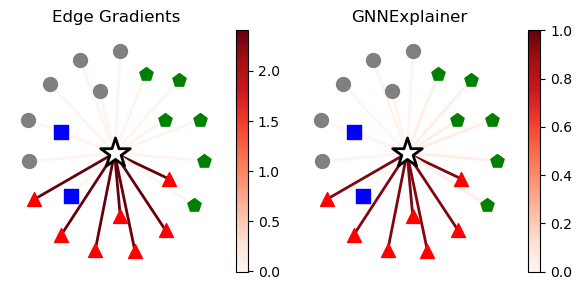

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
pos = nx.shell_layout(G)
pos[index] = (0,0)
pos = nx.spring_layout(G, pos = pos, fixed = [index])
for i in range(2):
    for j in range(G.number_of_nodes()):
        nodes = nx.draw_networkx_nodes(
            draw_graph, pos, ax = ax[i], node_color = node_color[j], node_size=100,
            node_shape = node_shape[j], nodelist = [list(G.nodes())[j]]
            )
    nodes = nx.draw_networkx_nodes(
        draw_graph, pos, ax = ax[i], nodelist = [index], node_color = 'white',
        node_shape = '*', linewidths = 2., edgecolors='black', node_size=500
        )
gi_edges = nx.draw_networkx_edges(
    draw_graph, pos, ax = ax[0], width=2.0,
    edge_color = [draw_graph[u][v]['GradientXInput'] for u, v in draw_graph.edges],
    edge_cmap = colormaps['Reds'],
    )
gnn_edges = nx.draw_networkx_edges(
    draw_graph, pos, ax = ax[1], width=2.0,
    edge_color = [draw_graph[u][v]['GNNExplainer'] for u, v in draw_graph.edges],
    edge_cmap = colormaps['Reds'], edge_vmin = 0, edge_vmax = 1
    )
fig.colorbar(gi_edges, ax=ax[0])
fig.colorbar(gnn_edges, ax=ax[1])
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].title.set_text('Edge Gradients')
ax[1].title.set_text('GNNExplainer')
plt.tight_layout()

In [13]:
eps = 0.001
out = model(test_data.x, test_data.edge_index)[test_data.nodes_to_test].cpu()
gi_masks = torch.stack(
    [gi_expl.edge_mask.cpu() > eps for gi_expl, pred in zip(gi_expls, out)]
)
gnn_masks = torch.stack(
    [gnn_expl.edge_mask.cpu() for gnn_expl in gnn_class_expls]
)
print(torch.nn.functional.cosine_similarity(gi_masks, gnn_masks, 1).mean(), torch.nn.functional.cosine_similarity(gi_masks, gnn_masks, 1).std())

tensor(0.9977) tensor(0.0038)
